# Train, evaluate, and test


## Lab setup

### Install Custom Vision Service SDK

In [ ]:
# Install Custom Vision Service SDK  in the current Jupyter kernel
import sys
!{sys.executable} -m pip install azure-cognitiveservices-vision-customvision

### Get example images


### Get example images


In [ ]:
%%sh
wget -nv https://azureailabs.blob.core.windows.net/aerialsamples/aerial.zip
unzip aerial.zip

### Get the training and prediction keys
To get the keys used in this example, navigate to Custom Vision Training blade in Azure Portal and retrieve the training key from the **Keys** page under **Resource Management** section. Repeat for Custom Vision Prediction service.

In [ ]:
from azure.cognitiveservices.vision.customvision.training import training_api

training_key = '<your training key>'
prediction_key = '<your prediction key>'

trainer = training_api.TrainingApi(training_key)

In [1]:
from azure.cognitiveservices.vision.customvision.training import training_api

training_key = 'b1cbbf0f9a054ef481113c9efec1fe4d'
prediction_key = 'b01851d0bbe24e9ba3c542ce84306787'

trainer = training_api.TrainingApi(training_key)

### Create a Custom Vision Service project

In [2]:
project_name = 'AerialClassifier'

# Check if the project with that name exists
project_id = None
for project in trainer.get_projects():
    if project.name == project_name:
        project_id = project.id
        print("Found existing project: {0}".format(project_id))
        break
# Create a new project        
if project_id == None:
    print("Creating a new project")
    project = trainer.create_project(project_name)
    project_id = project.id


Creating a new project


## Train

### Upload and tag images 
The API used to upload images `create_images_from_files` uploads a batch of images at a time. The maximum supported batch size is 64. 

In [3]:
import os
from azure.cognitiveservices.vision.customvision.training.models import ImageFileCreateEntry, Region

# Define a utility function to upload a list of images
def upload_images(training_key, project_id, image_list, batch_size=64):
    trainer = training_api.TrainingApi(training_key)
    print("Starting upload ...")
    image_batches = [image_list[start: start+batch_size] for start in range(0, len(image_list), batch_size)]
    for batch in image_batches:
        image_entry_batch = []
        for tag, pathname, file_name in batch:
            with open(pathname, mode='rb') as image_contents:
                image_entry_batch.append(ImageFileCreateEntry(name=file_name, contents=image_contents.read(), tag_ids=[tag]))
        summary = trainer.create_images_from_files(project_id, images=image_entry_batch)
    print("Done.")
    return summary


In [5]:
# Create tags. Check for existing tags before creating new ones
tags = trainer.get_tags(project_id)
if len(tags) == 0:
    tags = [trainer.create_tag(project_id, tag) for tag in ['Barren', 'Developed', 'Cultivated']]

tag_map = {tag.name: tag.id for tag in tags}

# Upload images
base_folder = 'aerial/train'
image_list = [(tag_map[folder], os.path.join(base_folder, folder, filename), filename)  for folder in ['Barren','Cultivated', 'Developed'] for filename in os.listdir(os.path.join(base_folder, folder))]
summary = upload_images(training_key, project_id, image_list, batch_size = 64)


Starting upload ...
Done.


### Train the first iteration of the project


In [6]:
import time

def train(training_key, project_id):
    trainer = training_api.TrainingApi(training_key)
    print("Starting training...")
    try:
        iteration = trainer.train_project(project_id)
        while (iteration.status != "Completed"):
            time.sleep(2)
            iteration = trainer.get_iteration(project_id, iteration.id)
            print ("Training status: " + iteration.status)      
        # The iteration is now trained. Make it the default project endpoint
        print("Training completed")
        trainer.update_iteration(project_id, iteration.id, is_default=True)
    except:
        print("No need to retrain. Retrieving default iteration")
        for iteration in trainer.get_iterations(project_id):
            if iteration.is_default:
                break

    return iteration.id

In [10]:
# Start training
iteration_id = train(training_key, project_id)

Starting training...
No need to retrain. Retrieving default iteration


### Get iteration performance 

In [11]:
def display_iteration_performance(training_key, project_id, iteration_id):
    trainer = training_api.TrainingApi(training_key)
    performance = trainer.get_iteration_performance(project_id, iteration_id)
    print("Overall Precision: {0:<10}".format(performance.precision))
    print("Overall Recall:    {0:<10}".format(performance.recall))
    for tag_perf in performance.per_tag_performance:
        print("Tag: {0:<15} Precision: {1:<10}   Recall: {2:<10}".format(tag_perf.name, tag_perf.precision, tag_perf.recall))

In [12]:
display_iteration_performance(training_key, project_id, iteration_id)

Overall Precision: 0.9902977 
Overall Recall:    0.913333356
Tag: Barren          Precision: 1.0          Recall: 0.933333337
Tag: Cultivated      Precision: 0.978198946   Recall: 0.9       
Tag: Developed       Precision: 0.9929078    Recall: 0.9066667 


### Upload additional images

In [13]:
# Upload images
base_folder = 'aerial/train'
folder = 'Developed-SecondBatch'
image_list = [(tag_map['Developed'], os.path.join(base_folder, folder, filename), filename)  for filename in os.listdir(os.path.join(base_folder, folder))]

summary = upload_images(training_key, project_id, image_list, batch_size = 64)

Starting upload ...
Done.


### Re-train the project


In [14]:
# Start training
iteration_id = train(training_key, project_id)

Starting training...
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Completed
Training completed


In [15]:
display_iteration_performance(training_key, project_id, iteration_id)

Overall Precision: 0.9896605 
Overall Recall:    0.9519996 
Tag: Barren          Precision: 1.0          Recall: 0.98      
Tag: Cultivated      Precision: 0.9791667    Recall: 0.92      
Tag: Developed       Precision: 0.9896635    Recall: 0.9550731 


## Test

### Download test images

In [16]:
%%sh
mkdir test_images
cd test_images
wget -nv https://github.com/jakazmie/AIDays/raw/master/DeveloperTrack/01-CustomVisionService/samples/barren-1.png
wget -nv https://github.com/jakazmie/AIDays/raw/master/DeveloperTrack/01-CustomVisionService/samples/cultivated-1.png
wget -nv https://github.com/jakazmie/AIDays/raw/master/DeveloperTrack/01-CustomVisionService/samples/developed-1.png

mkdir: test_images: File exists
2018-10-13 10:47:49 URL:https://raw.githubusercontent.com/jakazmie/AIDays/master/DeveloperTrack/01-CustomVisionService/samples/barren-1.png [91989/91989] -> "barren-1.png.2" [1]
2018-10-13 10:47:50 URL:https://raw.githubusercontent.com/jakazmie/AIDays/master/DeveloperTrack/01-CustomVisionService/samples/cultivated-1.png [79841/79841] -> "cultivated-1.png.2" [1]
2018-10-13 10:47:51 URL:https://raw.githubusercontent.com/jakazmie/AIDays/master/DeveloperTrack/01-CustomVisionService/samples/developed-1.png [92096/92096] -> "developed-1.png.2" [1]


### Display test images

The images we will use for testing are located in the `samples` folder.

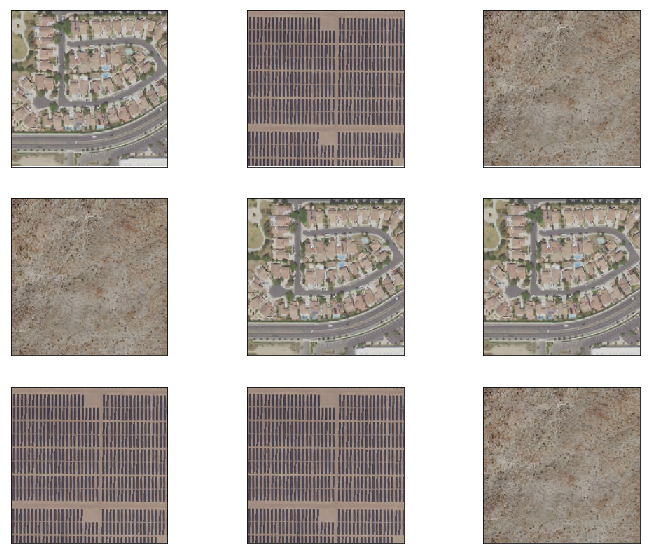

In [17]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

images_dir = 'test_images'
images = [os.path.join(images_dir, file) for file in os.listdir(images_dir)]

figsize=(10, 8)
fig, axis = plt.subplots(len(images)//3, 3, figsize=figsize)
fig.tight_layout()
for ax, image_path in zip(axis.flat[0:], images):
    image = Image.open(image_path)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.imshow(image)

 ### Test with `curl`
 

In [18]:
%env PROJECT_ID=$project_id
%env PREDICTION_KEY=$prediction_key

env: PROJECT_ID=b98fe4b6-18c1-4044-9788-899ec511a30f
env: PREDICTION_KEY=b01851d0bbe24e9ba3c542ce84306787


In [19]:
%%sh

curl -X POST https://southcentralus.api.cognitive.microsoft.com/customvision/v2.0/Prediction/$PROJECT_ID/image -H "Prediction-Key: $PREDICTION_KEY"  -H "Content-Type: application/octet-stream" --data-binary @test_images/developed-1.png

{"id":"f8630486-30ba-4d5c-8abc-b03383971a1b","project":"b98fe4b6-18c1-4044-9788-899ec511a30f","iteration":"b1c15192-b493-4e17-a24b-bc4f26694b18","created":"2018-10-13T17:47:59.1513854Z","predictions":[{"probability":0.9995019,"tagId":"2004b659-a87d-4673-a507-9db64a2cb5a5","tagName":"Developed"},{"probability":0.00755663263,"tagId":"d03d2bc1-f8b0-43f0-b5ed-1f2eb93a4e56","tagName":"Cultivated"},{"probability":9.00798E-06,"tagId":"d14b8ab1-2013-4bc7-9a57-8b0af51644cd","tagName":"Barren"}]}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 92587  100   491  100 92096    692   126k --:--:-- --:--:-- --:--:--  127k


### Call the prediction endpoint using Python SDK

Python SDK wraps the prediction endpoint in the `prediction_endpoint` class. The class exposes the `predict_image` method that takes a Python File Object as parameter. The following code snippet defines a utility function `classify_image` that invokes the prediction endpoint and parses the results returned from the service.

In [20]:
from azure.cognitiveservices.vision.customvision.prediction import prediction_endpoint
from azure.cognitiveservices.vision.customvision.prediction.prediction_endpoint import models

def classify_image(project_id, prediction_key, image_path):
    predictor = prediction_endpoint.PredictionEndpoint(prediction_key)
    with open(image_path, mode='rb') as image:
      result = predictor.predict_image(project_id, image)    
    probs = [prediction.probability for prediction in result.predictions]
    max_prob = max(probs)
    max_index = probs.index(max_prob)
    tag = result.predictions[max_index].tag_name

    return tag, max_prob

We will now invoke the prediction endpoint and display the results returned by the service.

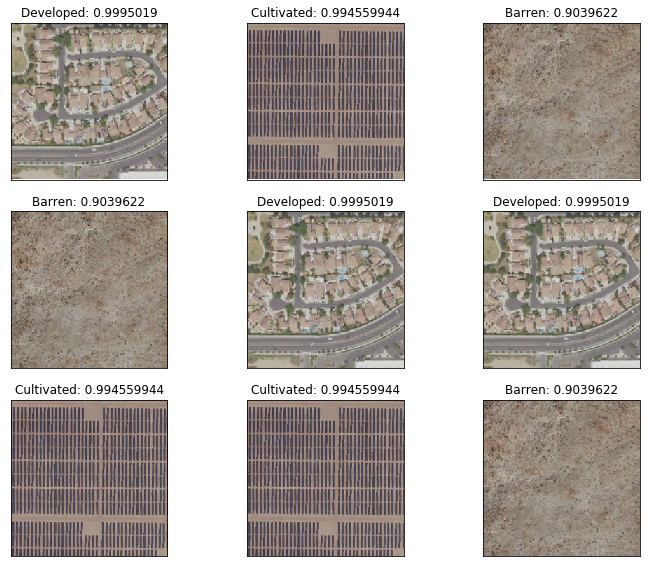

In [21]:
figsize=(10, 8)
fig, axis = plt.subplots(len(images)//3, 3, figsize=figsize)
fig.tight_layout()
for ax, image_path in zip(axis.flat[0:], images):
    tag, prob = classify_image(project_id, prediction_key, image_path)
    ax.set_title(tag + ': ' + str(prob))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    image = Image.open(image_path)
    ax.imshow(image)